# Observation Baseline Before/After Pilot Start
Weekends have been ommited (for now) since there is insufficient data.

In [18]:
%matplotlib inline
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
from datetime import datetime, timedelta, date
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pandas.io.sql as pandasql
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [19]:
# setting up pgsql connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

Baseline code taken from [bluetooth baseline anaylsis](https://github.com/CityofToronto/bdit_king_pilot_dashboard/blob/data_pipeline/bluetooth/bluetooth_baselines.ipynb). It has been modified to perform analysis on number of observations before/after King Street Pilot.

In [20]:
cut_days = ['2017-10-22', '2017-11-19']

Removes invalid days.

In [21]:
cut_day_str = '(\'' + cut_days[0]
for day in cut_days[1:]:
    cut_day_str = cut_day_str + '\', \'' + day
cut_day_str = cut_day_str + '\')'

In [22]:
def get_after_data(street):
    sql_mod = pg.SQL('''
    WITH bt as(
        SELECT * 
            FROM ryu4.aggr_30min blu
            WHERE blu.datetime_bin::date NOT IN ('2017-10-22', '2017-11-19')
            AND datetime_bin::date > '2017-11-11')
    SELECT '2017-11-12'::date + datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.obs) as observations,
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
        aa.report_name
    FROM  bt
        INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    WHERE hol.dt is NULL AND EXTRACT(ISODOW FROM bt.datetime_bin) < 6
        AND aa.report_name = {street}
    GROUP BY aa.report_name, 
        datetime_bin::time, 
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
    ''').format(street = pg.Literal(street))
    after_base = pandasql.read_sql(sql_mod, con)
    return after_base

In [23]:
def get_before_data(street):
    sql_mod = pg.SQL('''
    WITH bt as(
        SELECT * 
            FROM ryu4.aggr_30min blu
            WHERE blu.datetime_bin::date NOT IN ('2017-10-22', '2017-11-19')
            AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
            AND datetime_bin::date < '2017-11-12')
    SELECT '2017-11-12'::date + datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.obs) as observations,
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
        aa.report_name
    FROM  bt
        INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    WHERE hol.dt is NULL AND EXTRACT(ISODOW FROM bt.datetime_bin) < 6
        AND aa.report_name = {street}
    GROUP BY aa.report_name, 
        datetime_bin::time, 
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
    ''').format(street = pg.Literal(street))
    before_base = pandasql.read_sql(sql_mod, con)
    return before_base

In [24]:
colors = ['#003A72', '#d83904']

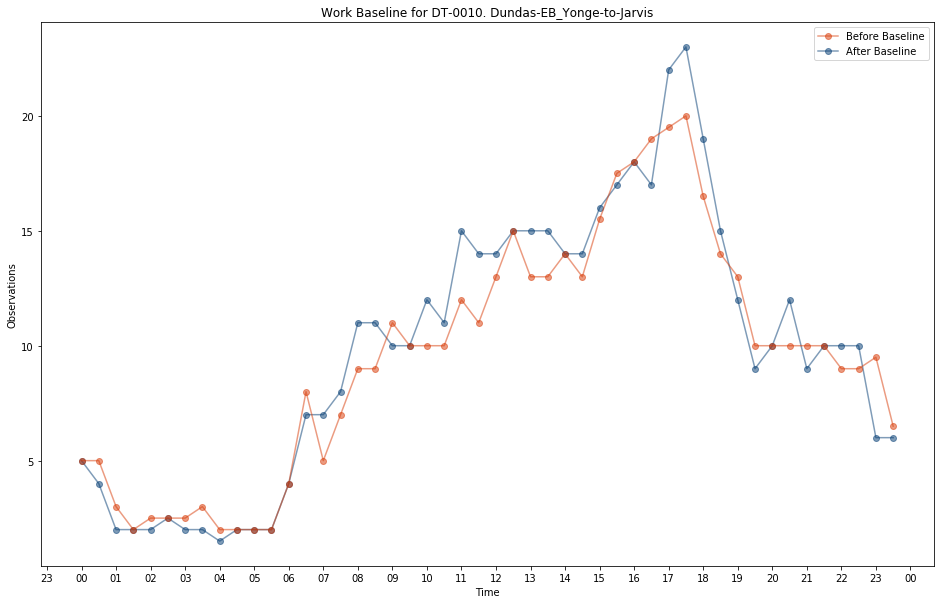

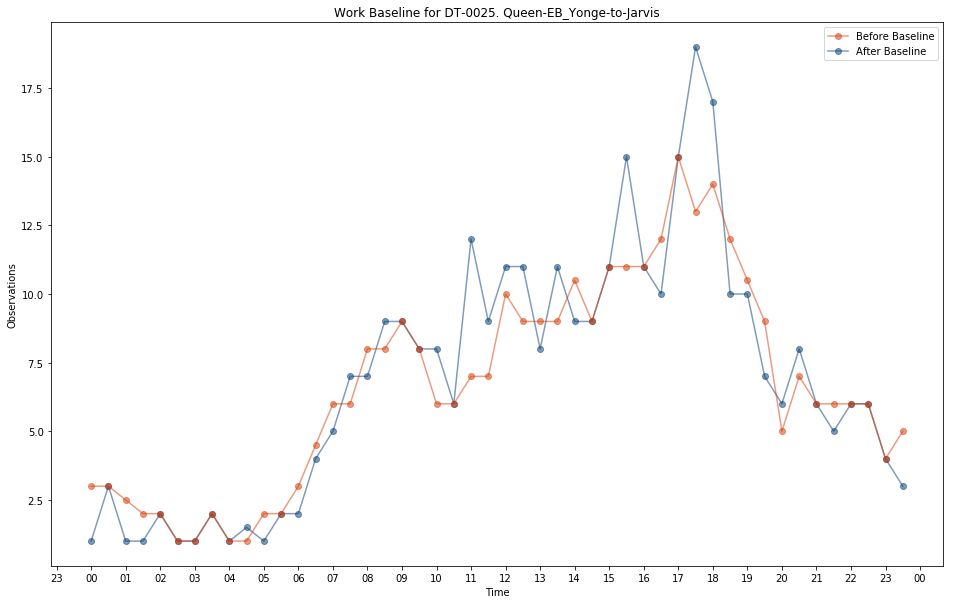

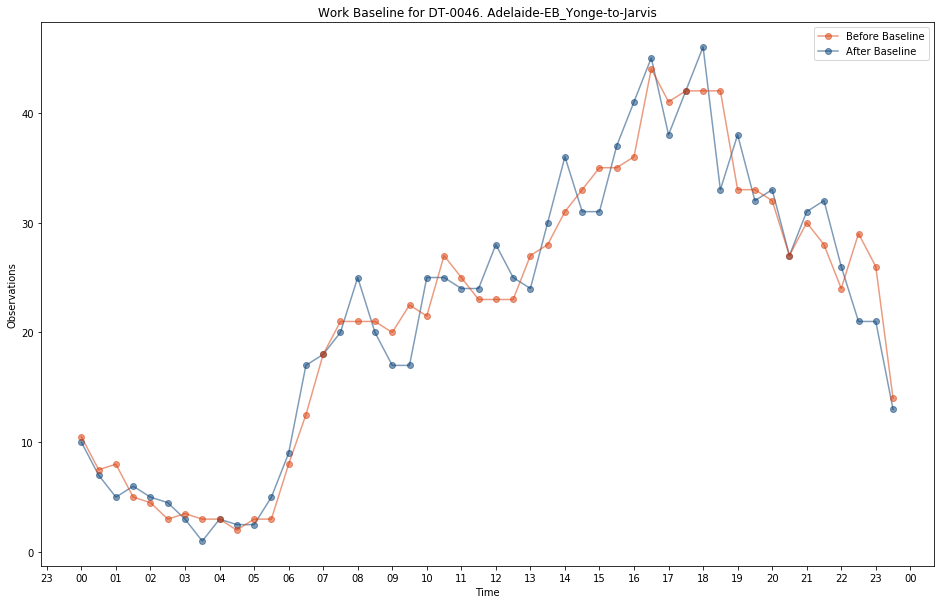

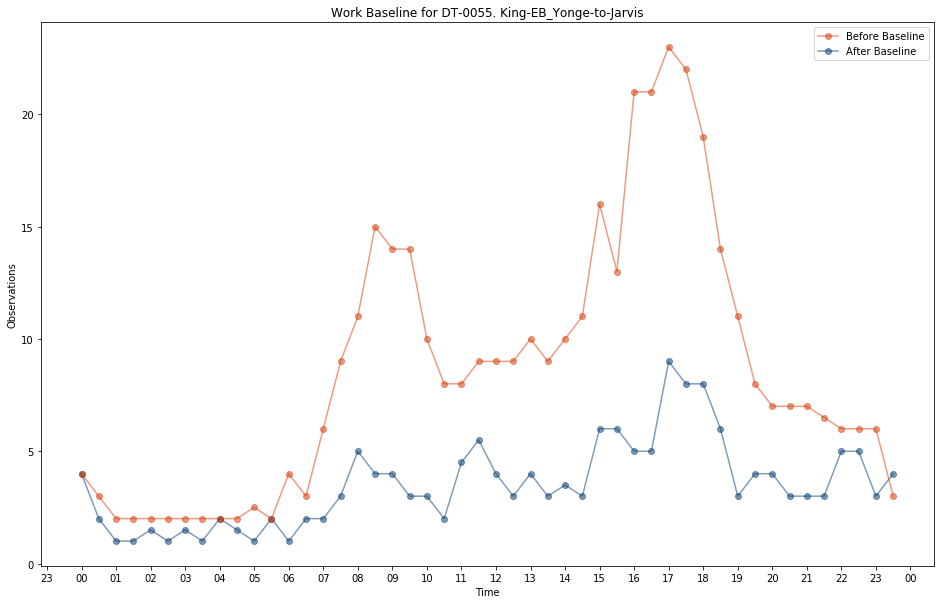

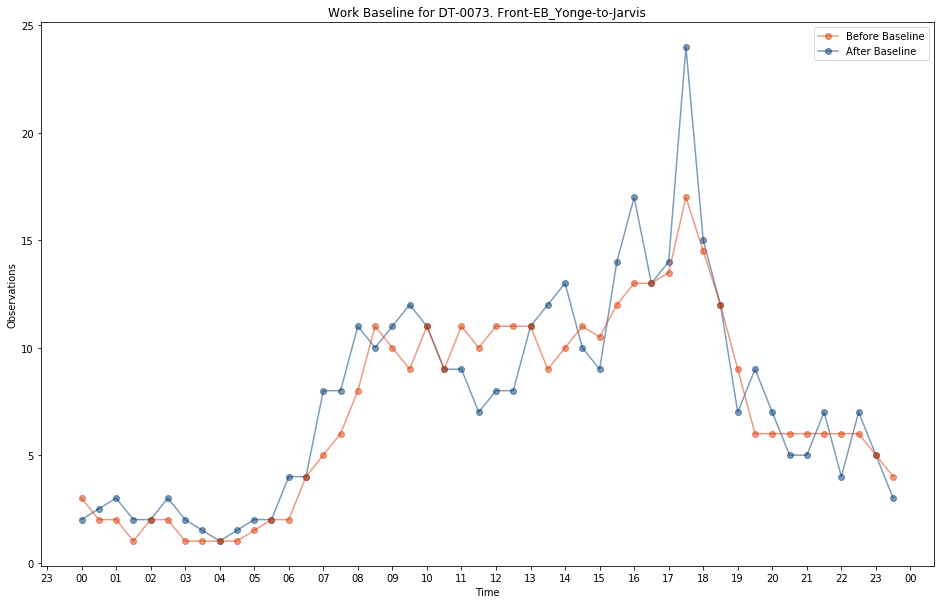

In [25]:
sample_set = ['DT-0010. Dundas-EB_Yonge-to-Jarvis', 'DT-0025. Queen-EB_Yonge-to-Jarvis',
              'DT-0046. Adelaide-EB_Yonge-to-Jarvis', 'DT-0055. King-EB_Yonge-to-Jarvis',
              'DT-0073. Front-EB_Yonge-to-Jarvis']
for street in sample_set:
    before = get_before_data(street)
    after = get_after_data(street)
    fig, ax = plt.subplots(1, 1, figsize = (16,10))

    after_baseline = ax.plot(after.time,
                after.observations.values,
                '-o',
                c = colors[0],
                alpha = 0.5)
    before_baseline = ax.plot(before.time,
                before.observations,
                '-o',
                c = colors[1],
                alpha = 0.5)
    plt.title(str('Work') + ' Baseline for ' + street)
    ax.xaxis.set_label_text('Time')
    ax.yaxis.set_label_text('Observations')
    ax.legend((before_baseline[0], after_baseline[0]), ('Before Baseline', 'After Baseline'))
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

    plt.show()


# Peak Time Changes

Percentage change of Normalized AM peak time observation changes

In [26]:
def get_peak_changes(ew_street, ns_segment, start, end):
    sql_mod = pg.SQL('''
    WITH after as (
        WITH bt as(
            SELECT * 
                FROM ryu4.aggr_30min blu
                WHERE blu.datetime_bin::date NOT IN ('2017-10-22', '2017-11-19')
                AND datetime_bin::date > '2017-11-11'
                AND blu.report_name SIMILAR TO {ew_street}
                AND blu.report_name SIMILAR TO {ns_segment})
        SELECT
            percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.obs) as observations,
            CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
            aa.report_name
        FROM  bt
            INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
            LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
        WHERE hol.dt is NULL AND EXTRACT(ISODOW FROM bt.datetime_bin) < 6
            AND bt.datetime_bin::time >= {start} AND bt.datetime_bin::time <= {end}
        GROUP BY aa.report_name, 
            CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
    ),
    before as(
        WITH bt as(
            SELECT * 
                FROM ryu4.aggr_30min blu
                WHERE blu.datetime_bin::date NOT IN ('2017-10-22', '2017-11-19')
                AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
                AND datetime_bin::date < '2017-11-12'
                AND blu.report_name SIMILAR TO {ew_street}
                AND blu.report_name SIMILAR TO {ns_segment})
        SELECT
            percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.obs) as observations,
            CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
            aa.report_name
        FROM  bt
            INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
            LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
        WHERE hol.dt is NULL AND EXTRACT(ISODOW FROM bt.datetime_bin) < 6
            AND bt.datetime_bin::time >= {start} AND bt.datetime_bin::time <= {end}
        GROUP BY aa.report_name, 
            CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
    )
    SELECT after.observations AS after_obs, before.observations AS before_obs, 
            round(((after.observations - before.observations) / before.observations) * 100) AS pct_chg
    FROM after
    INNER JOIN before ON before.report_name = after.report_name
    ''').format(ew_street = pg.Literal('% ' + ew_street + '-%'), ns_segment = pg.Literal('%' + ns_segment), 
                start = pg.Literal(start), end = pg.Literal(end))
    pct_change = pandasql.read_sql(sql_mod, con)
    return pct_change

## AM Peak Time Changes

In [27]:
am_peak_start = '7:00:00'
am_peak_end = '10:00:00'

ew_streets = ['Queen', 'Richmond', 'Adelaide', 'King', 'Front']
ns_segments = ['Bathurst-to-Spadina', 'Spadina-to-Bathurst', 'Spadina-to-University', 'University-to-Spadina',
               'Yonge-to-Jarvis', 'Jarvis-to-Yonge', 'Jarvis-to-Parliament', 'Parliament-to-Jarvis']
obs_before_am = {}
obs_after_am = {}
pct_change_am = {}
for segment in ns_segments:
    segment_obs_before = {}
    segment_obs_after = {}
    segment_pct_change = {}
    for street in ew_streets:
        segment_data = get_peak_changes(street, segment, am_peak_start, am_peak_end)
        segment_obs_before[street] = '-' if len(segment_data.before_obs.values) == 0 else segment_data.before_obs.values[0]
        segment_obs_after[street] = '-' if len(segment_data.after_obs.values) == 0 else segment_data.after_obs.values[0]
        segment_pct_change[street] = '-' if len(segment_data.pct_chg.values) == 0 else str(segment_data.pct_chg.values[0])
    obs_before_am[segment] = segment_obs_before
    obs_after_am[segment] = segment_obs_after
    pct_change_am[segment] = segment_pct_change

In [28]:
print("AM Observations Before Pilot")
am_obs_before_table = pd.DataFrame.from_dict(obs_before_am)
HTML(am_obs_before_table.to_html(columns=ns_segments))

AM Observations Before Pilot


,Bathurst-to-Spadina,Spadina-to-Bathurst,Spadina-to-University,University-to-Spadina,Yonge-to-Jarvis,Jarvis-to-Yonge,Jarvis-to-Parliament,Parliament-to-Jarvis
Adelaide,-,-,22,-,21,-,20,-
Front,20,5,6,2,9,-,6,17
King,15,7,13,5,11,13,5,12
Queen,19,8,11,5.5,7,16,9,19
Richmond,-,7,-,9,-,36,-,50


In [29]:
print("AM Observations After Pilot")
am_obs_after_table = pd.DataFrame.from_dict(obs_after_am)
HTML(am_obs_after_table.to_html(columns=ns_segments))

AM Observations After Pilot


,Bathurst-to-Spadina,Spadina-to-Bathurst,Spadina-to-University,University-to-Spadina,Yonge-to-Jarvis,Jarvis-to-Yonge,Jarvis-to-Parliament,Parliament-to-Jarvis
Adelaide,-,-,20,-,20,-,20,-
Front,18,5,7,1,10,-,7,21
King,5,3,5,3,4,5,2,7
Queen,23,10,13,7,8,18,10,21
Richmond,-,6,-,8,-,37,-,46


In [30]:
print("AM Percentage Change After Pilot")
am_chg_table = pd.DataFrame.from_dict(pct_change_am)
for seg in ns_segments:
    for street in ew_streets:
        if am_chg_table[seg][street] != '-':
            am_chg_table[seg][street] = am_chg_table[seg][street] + '%'
HTML(am_chg_table.to_html(columns=ns_segments))

AM Percentage Change After Pilot


,Bathurst-to-Spadina,Spadina-to-Bathurst,Spadina-to-University,University-to-Spadina,Yonge-to-Jarvis,Jarvis-to-Yonge,Jarvis-to-Parliament,Parliament-to-Jarvis
Adelaide,-,-,-9.0%,-,-5.0%,-,0.0%,-
Front,-10.0%,0.0%,17.0%,-50.0%,11.0%,-,17.0%,24.0%
King,-67.0%,-57.0%,-62.0%,-40.0%,-64.0%,-62.0%,-60.0%,-42.0%
Queen,21.0%,25.0%,18.0%,27.0%,14.0%,12.0%,11.0%,11.0%
Richmond,-,-14.0%,-,-11.0%,-,3.0%,-,-8.0%


## PM Peak Time Changes

In [31]:
pm_peak_start = '16:00:00'
pm_peak_end = '19:00:00'

obs_before_pm = {}
obs_after_pm = {}
pct_change_pm = {}
for segment in ns_segments:
    segment_obs_before = {}
    segment_obs_after = {}
    segment_pct_change = {}
    for street in ew_streets:
        segment_data = get_peak_changes(street, segment, pm_peak_start, pm_peak_end)
        segment_obs_before[street] = '-' if len(segment_data.before_obs.values) == 0 else segment_data.before_obs.values[0]
        segment_obs_after[street] = '-' if len(segment_data.after_obs.values) == 0 else segment_data.after_obs.values[0]
        segment_pct_change[street] = '-' if len(segment_data.pct_chg.values) == 0 else segment_data.pct_chg.values[0]
    obs_before_pm[segment] = segment_obs_before
    obs_after_pm[segment] = segment_obs_after
    pct_change_pm[segment] = segment_pct_change

In [32]:
print("AM Observations Before Pilot")
am_obs_before_table = pd.DataFrame.from_dict(obs_before_am)
HTML(am_obs_before_table.to_html(columns=ns_segments))

AM Observations Before Pilot


,Bathurst-to-Spadina,Spadina-to-Bathurst,Spadina-to-University,University-to-Spadina,Yonge-to-Jarvis,Jarvis-to-Yonge,Jarvis-to-Parliament,Parliament-to-Jarvis
Adelaide,-,-,22,-,21,-,20,-
Front,20,5,6,2,9,-,6,17
King,15,7,13,5,11,13,5,12
Queen,19,8,11,5.5,7,16,9,19
Richmond,-,7,-,9,-,36,-,50


In [33]:
print("AM Observations After Pilot")
am_obs_after_table = pd.DataFrame.from_dict(obs_after_am)
HTML(am_obs_after_table.to_html(columns=ns_segments))

AM Observations After Pilot


,Bathurst-to-Spadina,Spadina-to-Bathurst,Spadina-to-University,University-to-Spadina,Yonge-to-Jarvis,Jarvis-to-Yonge,Jarvis-to-Parliament,Parliament-to-Jarvis
Adelaide,-,-,20,-,20,-,20,-
Front,18,5,7,1,10,-,7,21
King,5,3,5,3,4,5,2,7
Queen,23,10,13,7,8,18,10,21
Richmond,-,6,-,8,-,37,-,46


In [34]:
print("AM Percentage Change After Pilot")
pm_chg_table = pd.DataFrame.from_dict(pct_change_pm)
for seg in ns_segments:
    for street in ew_streets:
        if pm_chg_table[seg][street] != '-':
            pm_chg_table[seg][street] = pm_chg_table[seg][street].astype(str) + '%'
HTML(pm_chg_table.to_html(columns=ns_segments))

AM Percentage Change After Pilot


,Bathurst-to-Spadina,Spadina-to-Bathurst,Spadina-to-University,University-to-Spadina,Yonge-to-Jarvis,Jarvis-to-Yonge,Jarvis-to-Parliament,Parliament-to-Jarvis
Adelaide,-,-,-7.0%,-,0.0%,-,3.0%,-
Front,29.0%,12.0%,0.0%,0.0%,8.0%,-,0.0%,11.0%
King,-56.0%,-58.0%,-56.0%,-38.0%,-68.0%,-44.0%,-64.0%,-33.0%
Queen,22.0%,7.0%,12.0%,0.0%,0.0%,14.0%,6.0%,12.0%
Richmond,-,-4.0%,-,-4.0%,-,0.0%,-,0.0%
